## Importing Required Modules, Packages, and Libraries

In [2]:
pip install pmdarima

In [3]:
pip install arch

In [4]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


from arch import arch_model
from arch.univariate import ARX, GARCH, StudentsT, Normal

import warnings
warnings.filterwarnings("ignore")



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Dataset

In [6]:
stores_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Walmart Sales Forecasting Project/stores.csv')

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Walmart Sales Forecasting Project/train.csv') # train set

In [8]:
features_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Walmart Sales Forecasting Project/features.csv') #external information

## Joining all Dataframes

In [9]:
train_df.shape

(421570, 5)

In [10]:
train_df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [12]:
stores_df.shape

(45, 3)

In [13]:
stores_df.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [14]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [15]:
features_df.shape

(8190, 12)

In [16]:
features_df.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [17]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [18]:
# merging 3 different sets
df = train_df.merge(features_df, on=['Store', 'Date'], how='inner').merge(stores_df, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [19]:
df.rename(columns={'IsHoliday_x':'Holiday'},inplace=True) # rename the column

In [20]:
df.head() # last ready data set

,Store,Dept,Date,Weekly_Sales,Holiday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [21]:
df.shape

(421570, 17)

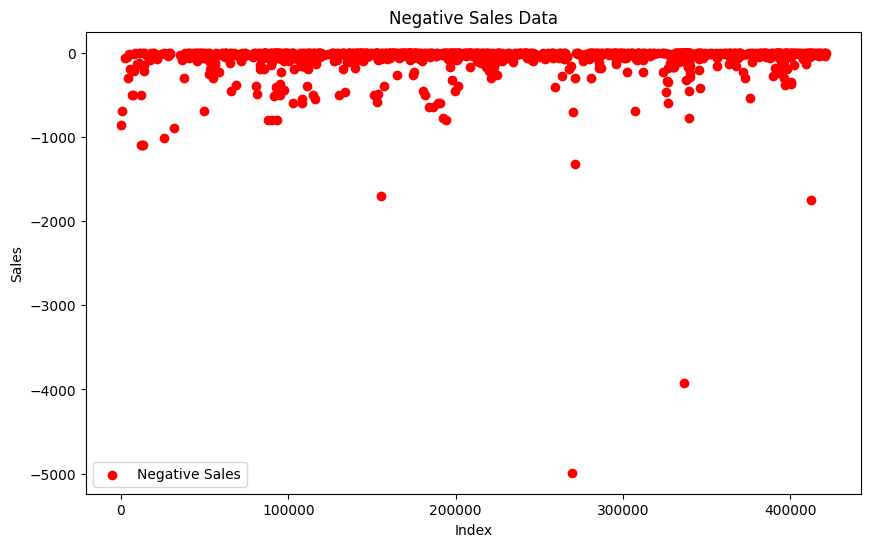

In [22]:
negative_sales = df[df['Weekly_Sales'] < 0]

# Plotting the negative sales values
plt.figure(figsize=(10, 6))
plt.scatter(negative_sales.index, negative_sales['Weekly_Sales'], color='red', label='Negative Sales')
plt.title('Negative Sales Data')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
df = df.loc[df['Weekly_Sales'] > 0]

In [24]:
df.shape # new data shape

(420212, 17)

## Promotion Dates Check

In [25]:
df['Date'].head(5).append(df['Date'].tail(5)) # to see first and last 5 rows.

0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

## Holiday

<Axes: xlabel='Holiday', ylabel='Weekly_Sales'>

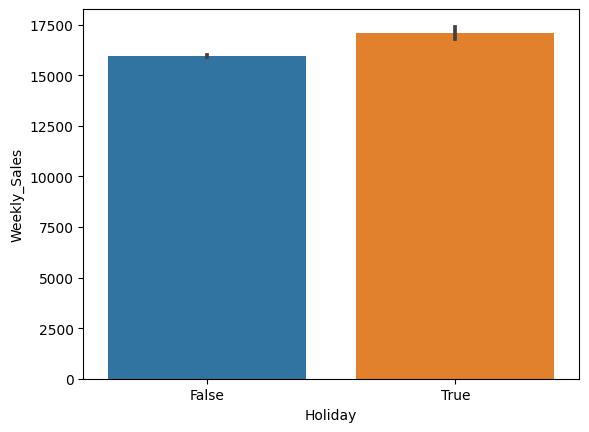

In [26]:
sns.barplot(x='Holiday', y='Weekly_Sales', data=df)

In [27]:
df_not_holiday = df.query('Holiday == True')
num_unique_dates = df_not_holiday['Date'].nunique()


In [28]:
df_not_holiday = df.query('Holiday == False')
num_unique_dates = df_not_holiday['Date'].nunique()


All holidays are not in the data. There are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13


After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

I want to see differences between holiday types. So, I create new columns for 4 types of holidays and fill them with boolean values. If date belongs to this type of holiday it is True, if not False.

In [29]:
super_bowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10']

df['Super_Bowl'] = df['Date'].isin(super_bowl_dates)


In [30]:
labor_day_dates = ['2010-09-10', '2011-09-09', '2012-09-07']

df['Labor_Day'] = df['Date'].isin(labor_day_dates)


In [31]:
thanksgiving_dates = ['2010-11-26', '2011-11-25']

df['Thanksgiving'] = df['Date'].isin(thanksgiving_dates)


In [32]:
christmas_dates = ['2010-12-31', '2011-12-30']

df['Christmas'] = df['Date'].isin(christmas_dates)


In [33]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
Holiday              0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [34]:
df = df.fillna(0) # filling null's with 0

In [35]:
df.isna().sum() # last null check

Store           0
Dept            0
Date            0
Weekly_Sales    0
Holiday         0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday_y     0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

## Walmart Sales Analysis



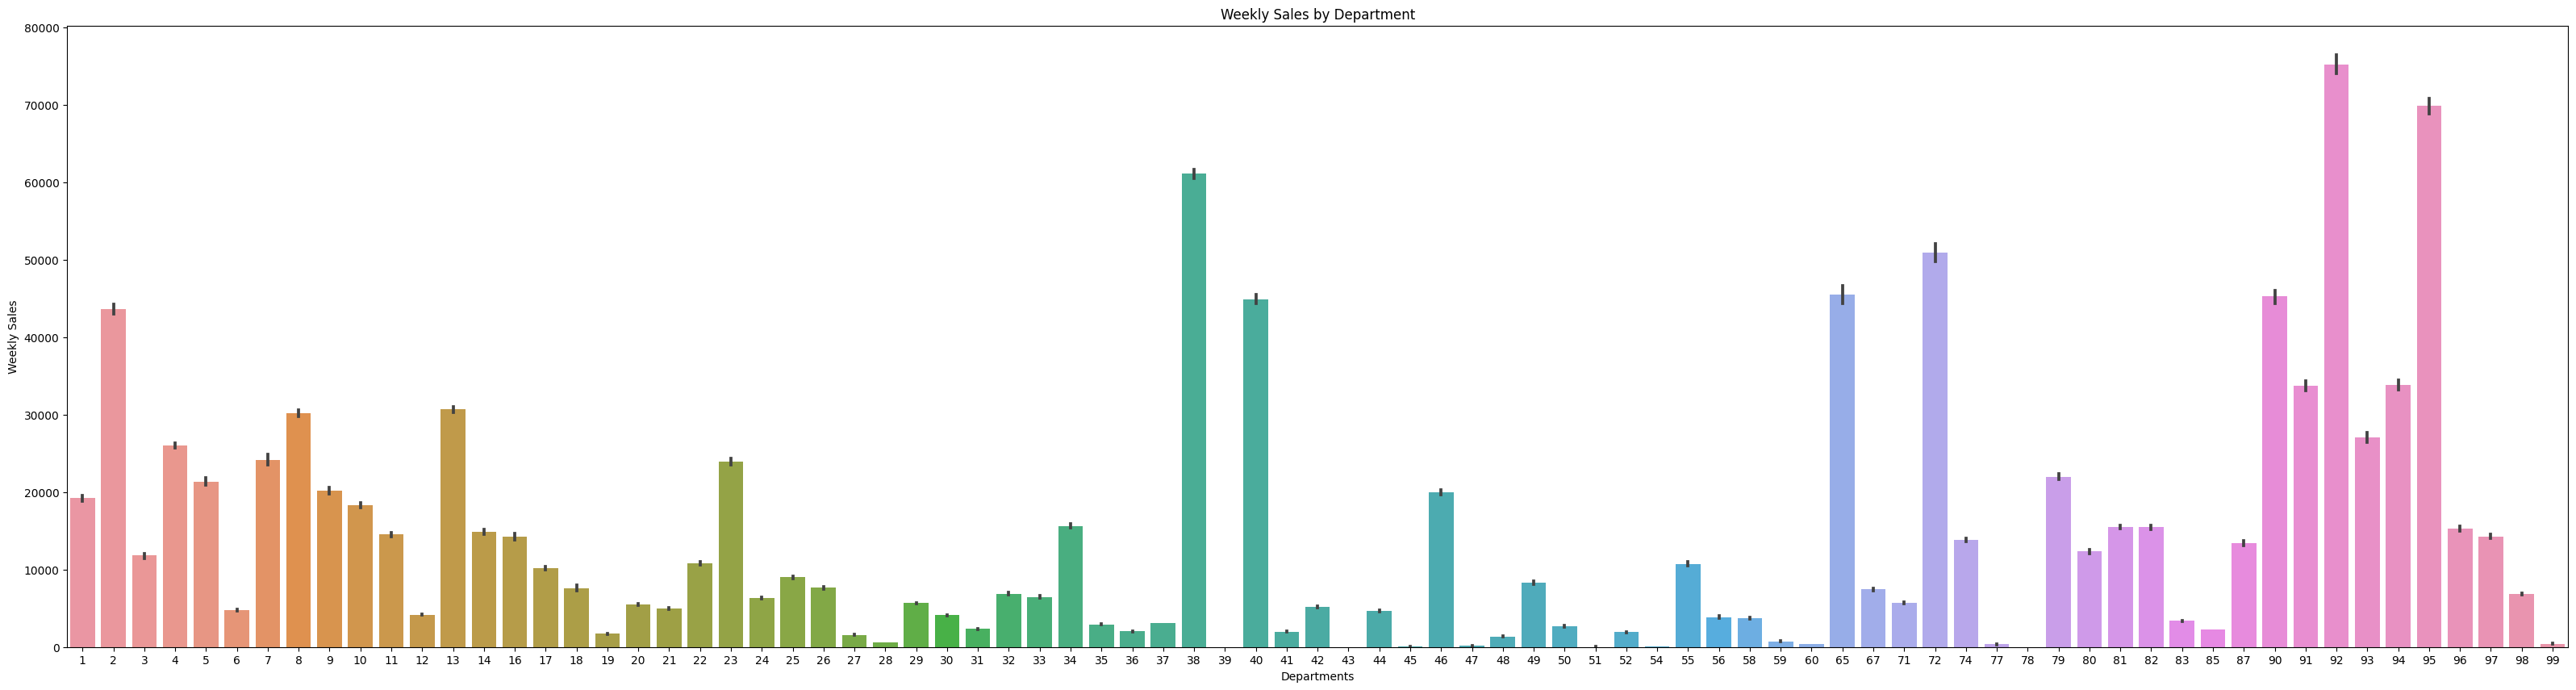

In [36]:
plt.figure(figsize=(40, 10))

x = df['Dept']
y = df['Weekly_Sales']

sns.barplot(x=x, y=y)

plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')

plt.show()

This provided us the knowledge as to which departments sold the most and as it is certainly useful at a descriptive level, we decided to explore the other end of the spectrum to see the behavior of various departments. Therefore, we looked at the smallest selling departments to identify some patterns, and found that a few are seasonal departments: 54 and 60 around Christmas and the week before, 99 was festivity based, and 28 for Halloween, while some departments are active around Thanksgiving, e.g. 48.








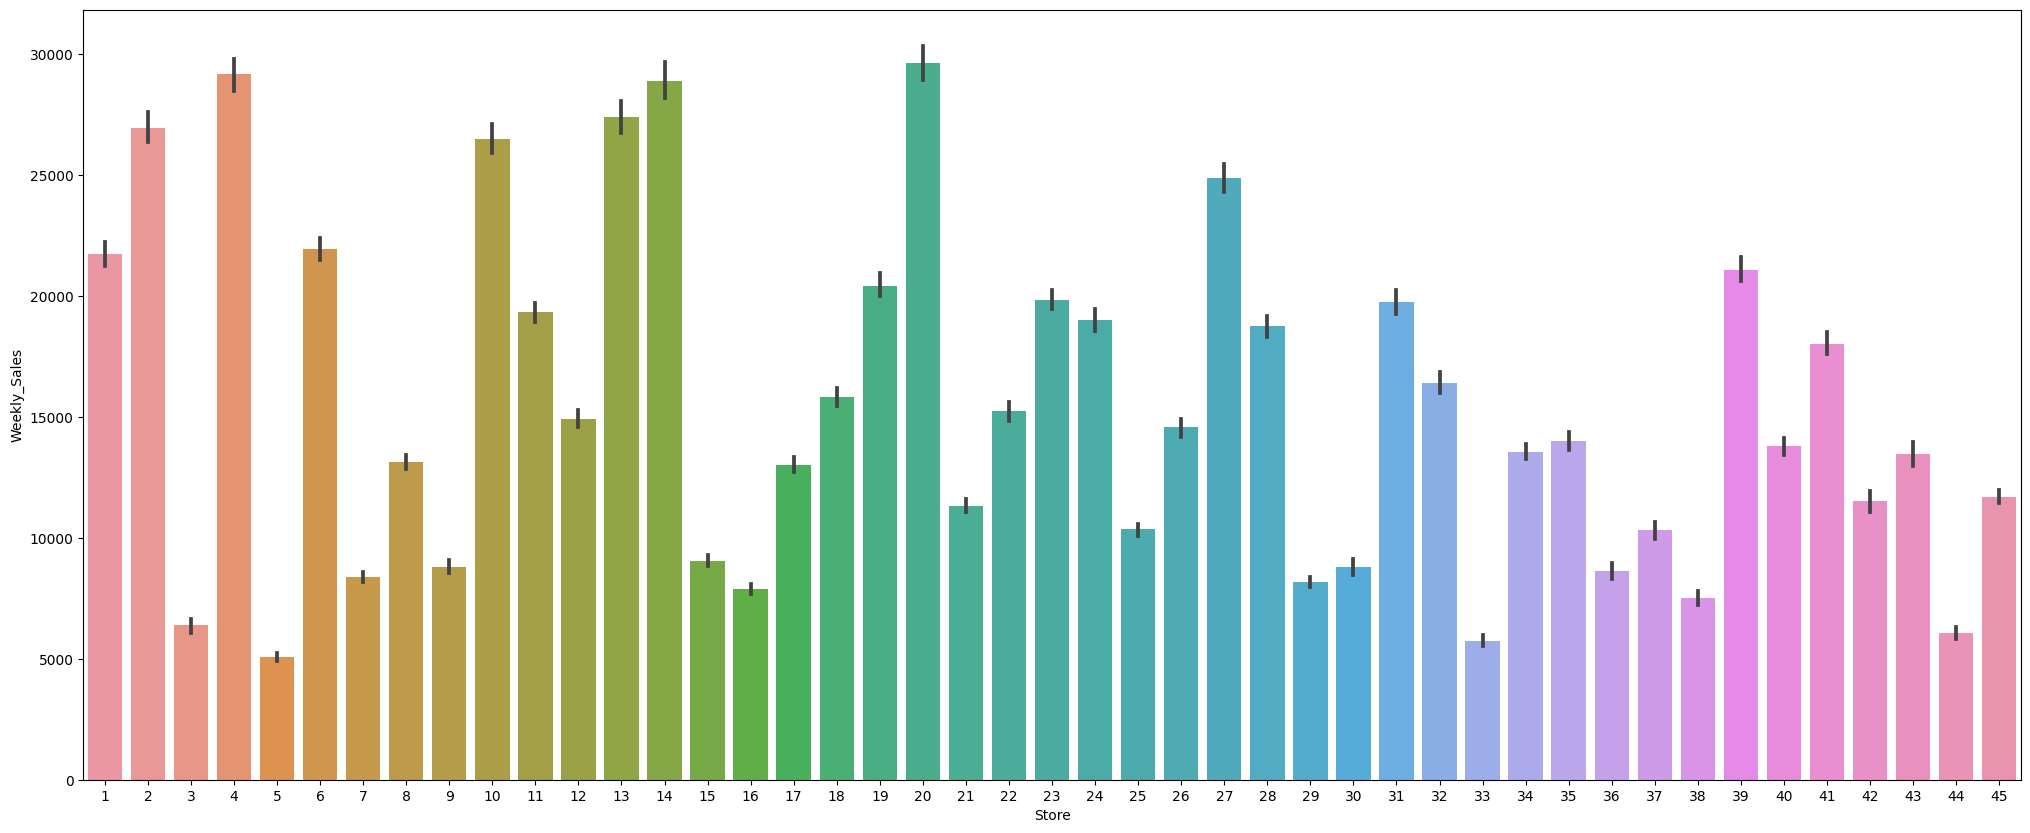

In [37]:
plt.figure(figsize=(25,10))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

Of the 81 departments, Department 92 was consistently outselling the other departments, with Department 95 and 38 representing the top three.

# Changing Date to Datetime and Creating New Columns

In [38]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['week'] =df['Date'].dt.week
df['month'] =df['Date'].dt.month
df['year'] =df['Date'].dt.year

In [39]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [40]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

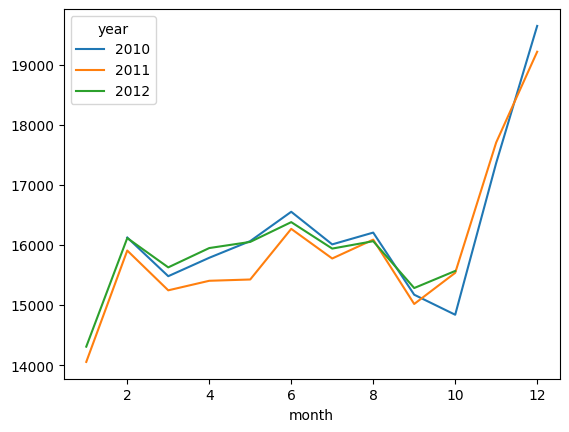

In [41]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

From the graph, it is seen that 2011 has lower sales than 2010 generally. When we look at the mean sales it is seen that 2010 has higher values, but 2012 has no information about November and December which have higher sales. Despite of 2012 has no last two months sales, it's mean is near to 2010. Most probably, it will take the first place if we get 2012 results and add them.

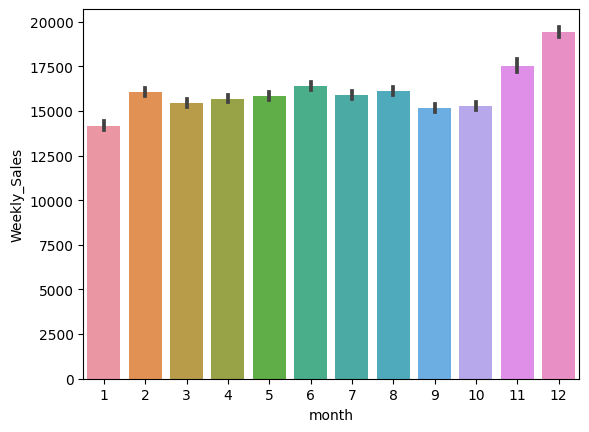

In [42]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

When we look at the graph above, the best sales are in December and November, as expected. The highest values are belongs to Thankgiving holiday but when we take average it is obvious that December has the best value.

In [43]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

Top 5 sales averages by weekly belongs to 1-2 weeks before Christmas, Thanksgiving, Black Friday and end of May, when the schools are closed.

<Axes: xlabel='week'>

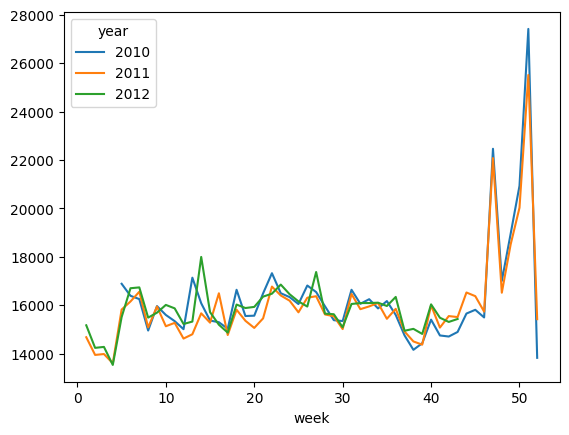

In [44]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

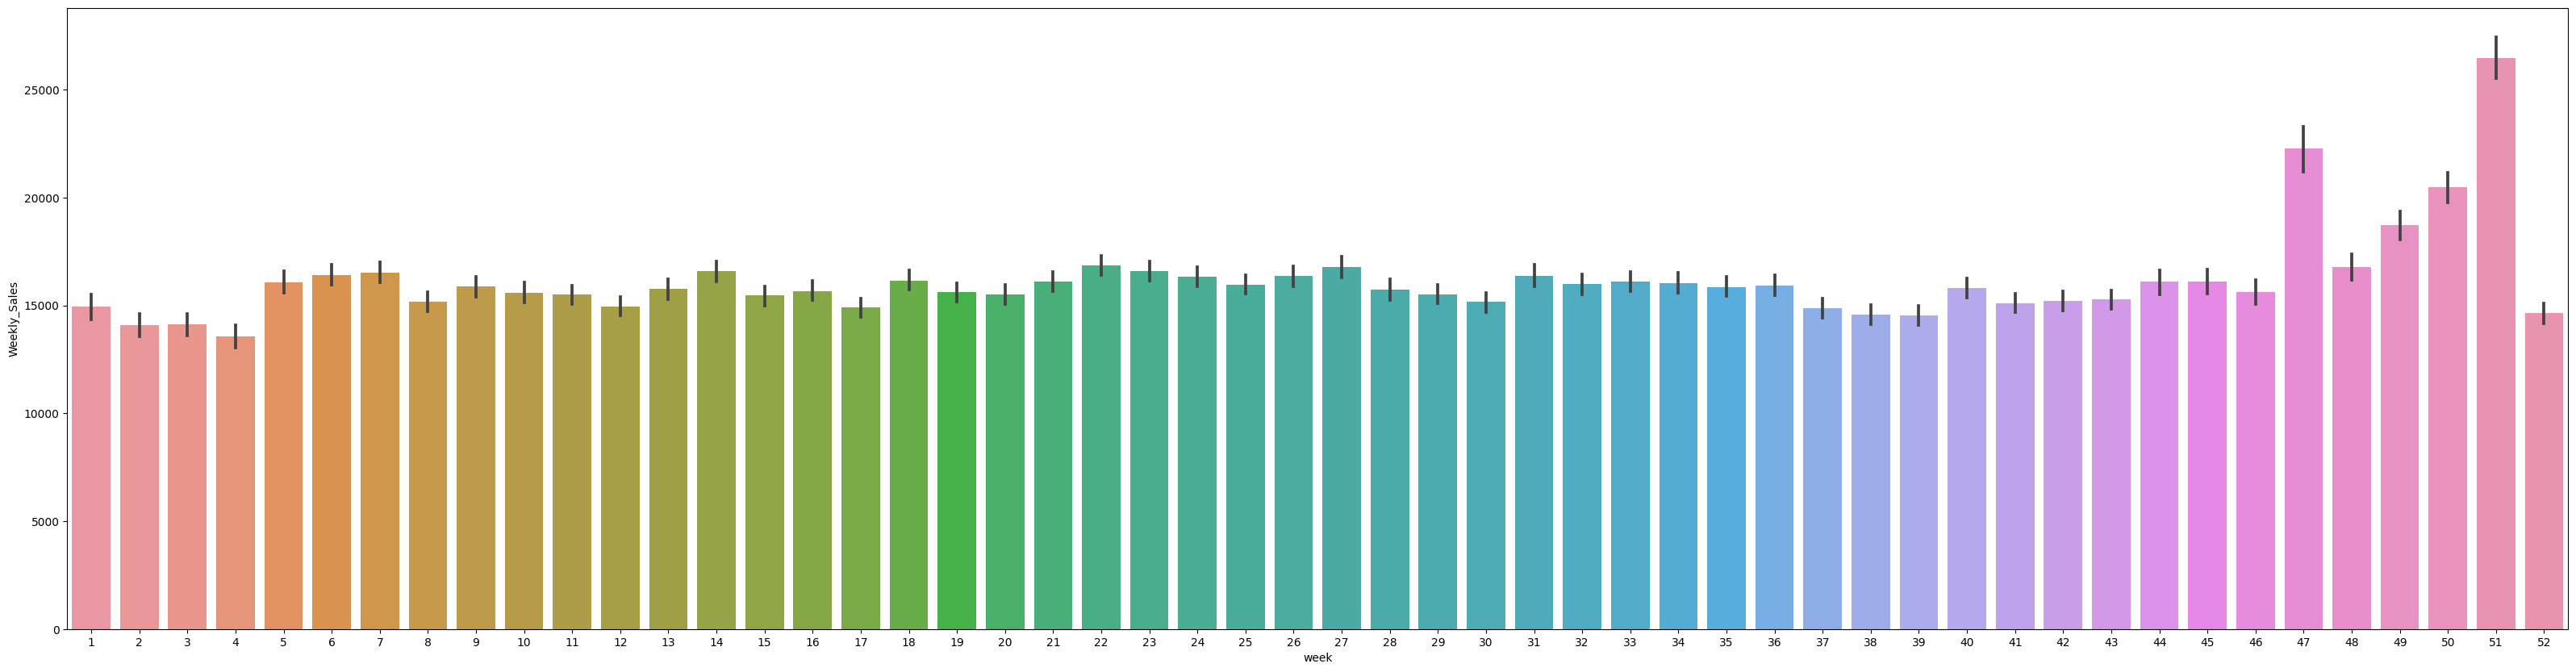

In [45]:
plt.figure(figsize=(40,10))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

In [46]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here

## Model Implementation

In [47]:
pd.options.display.max_columns=100 # to see columns

In [48]:
df = pd.read_csv('/content/clean_data.csv')

In [49]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [50]:
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

## Encoding the Data

In [51]:
df_encoded = df.copy() # to keep original dataframe taking copy of it

In [52]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [53]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1

In [54]:
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1

In [55]:
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1

In [56]:
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1

In [57]:
df_encoded['Holiday'] = df_encoded['Holiday'].astype(bool).astype(int) # changing T,F to 0-1

In [58]:
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

## Observation of Interactions between Features

Firstly, i will drop divided holiday columns from my data and try without them. To keep my encoded data safe, I assigned my dataframe to new one and I will use for this.

In [59]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

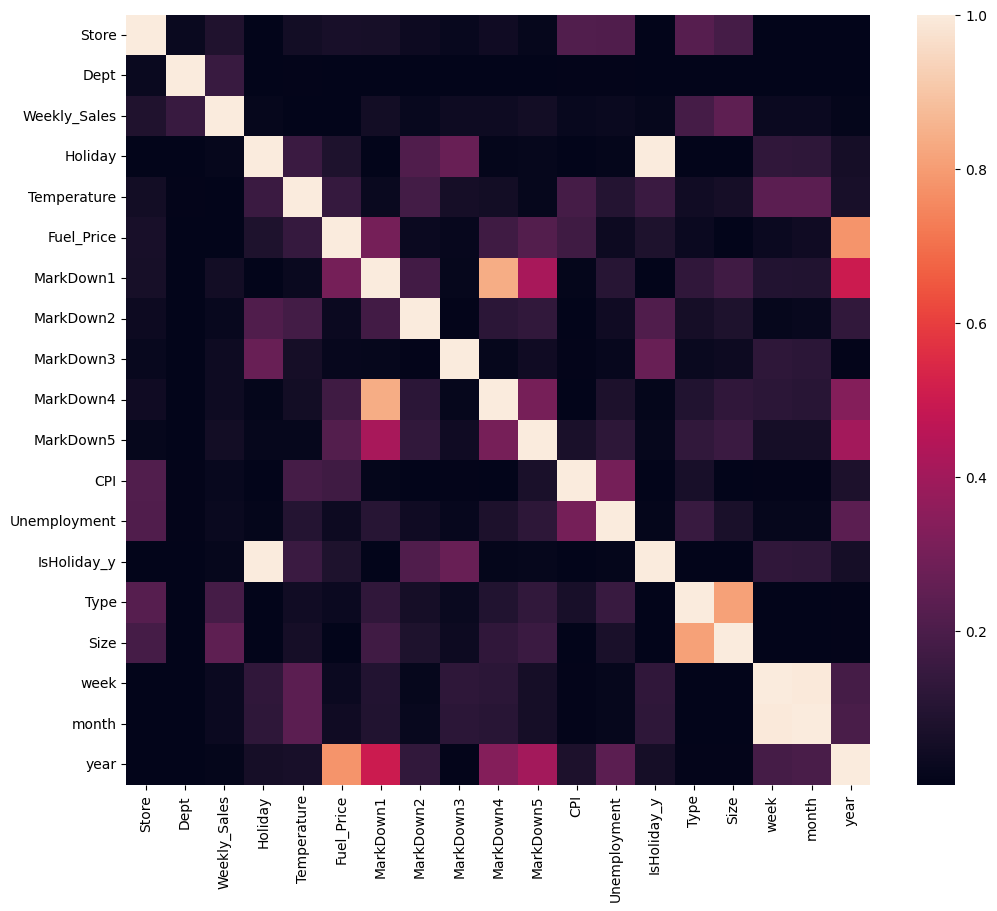

In [60]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations
plt.show()

Temperature, unemployment, CPI have no significant effect on weekly sales, so I will drop them. Also, Markdown 4 and 5 highly correlated with Markdown 1. So, I will drop them also. It can create multicollinearity problem, maybe. So, first I will try without them.

In [61]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales.

In [62]:
df_new = df_new.sort_values(by='Date', ascending=True) # sorting according to date

## Creating Train-Test Splits

Our date column has continuous values, to keep the date features continue, I will not take random splitting. so, I split data manually according to 70%.

In [63]:
train_data = df_new.iloc[:int(0.7 * len(df_new))]
test_data = df_new.iloc[int(0.7 * len(df_new)):]

target = "Weekly_Sales"
used_cols = df_new.columns.difference([target]).tolist()

X_train, X_test = train_data[used_cols], test_data[used_cols]
y_train, y_test = train_data[target], test_data[target]


In [64]:
X = df_new[used_cols]


We have enough information in our date such as week of the year. So, I drop date columns.

In [65]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

In [66]:
def wmae_test(test, pred): # WMAE for test
    weights = X_test['Holiday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

## Random Forest Regressor

In [67]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()



#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

In [68]:
wmae_test(y_test, y_pred_test)

6057.462694953542

In [69]:
# splitting train-test to whole dataset
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.to_list() if c not in [target]] # all columns except price

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
y_train_enc = train_data_enc[target]
y_test_enc = test_data_enc[target]

In [70]:
X_enc = df_encoded[used_cols1] # to get together train,test splits

In [71]:
X_enc = X_enc.drop(['Date'], axis=1) #dropping date column for whole X

In [72]:
X_train_enc = X_train_enc.drop(['Date'], axis=1) # dropping date from train and test
X_test_enc= X_test_enc.drop(['Date'], axis=1)

In [73]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, y_train_enc)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc)

In [74]:
wmae_test(y_test_enc, y_pred_test_enc)

2485.51069869358

## Linear Regression

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

# Define Linear Regression
lr = LinearRegression()

# Define RobustScaler
scaler_lr = RobustScaler()

# Create pipeline
pipe_lr = make_pipeline(scaler_lr, lr)

# Fit model on the training data
pipe_lr.fit(X_train_enc, y_train_enc)

# Make predictions on the training set
y_pred_lr = pipe_lr.predict(X_train_enc)

# Make predictions on the test set
y_pred_test_lr = pipe_lr.predict(X_test_enc)

# Calculate WMAE for Linear Regression on the test set
wmae_lr = wmae_test(y_test_enc, y_pred_test_lr)

print(f'WMAE for Linear Regression: {wmae_lr}')


WMAE for Linear Regression: 3757.2272324642922


## XG Boost Regressor

In [78]:
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

# Define XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=50, random_state=42)

# Define RobustScaler
scaler_xgb = RobustScaler()

# Create pipeline
pipe_xgb = make_pipeline(scaler_xgb, xgb)

# Fit model on the training data
pipe_xgb.fit(X_train_enc, y_train_enc)

# Make predictions on the training set
y_pred_xgb = pipe_xgb.predict(X_train_enc)

# Make predictions on the test set
y_pred_test_xgb = pipe_xgb.predict(X_test_enc)

# Calculate WMAE for XGBoost Regressor on the test set
wmae_xgb = wmae_test(y_test_enc, y_pred_test_xgb)

print(f'WMAE for XGBoost Regressor: {wmae_xgb}')


WMAE for XGBoost Regressor: 2268.929089926757


Best Model was XGBoost Regressor

## Implementing a Time Series Model



In [79]:
df.head() # to see my data

,Store,Dept,Date,Weekly_Sales,Holiday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,False,False,False,False,5,2,2010


In [80]:
df["Date"] = pd.to_datetime(df["Date"]) #changing data to datetime for decomposing

In [81]:
df.set_index('Date', inplace=True) #seting date as index

## Plotting Sales

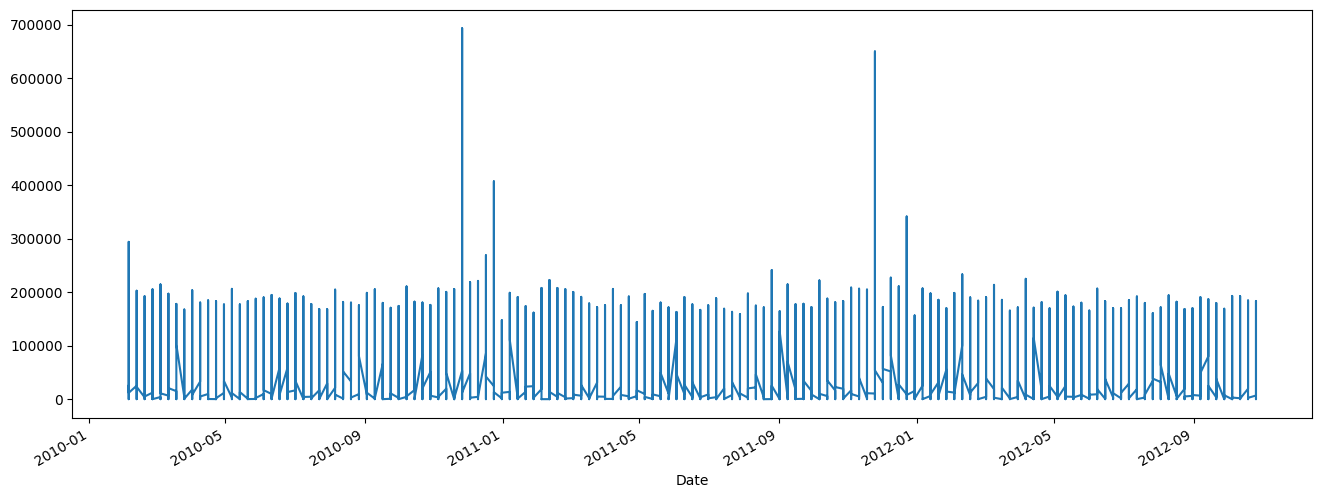

In [82]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In this data, there are lots of same data values. So, I will collect them together as weekly.

In [83]:
df_week = df.resample('W').mean() #resample data as weekly

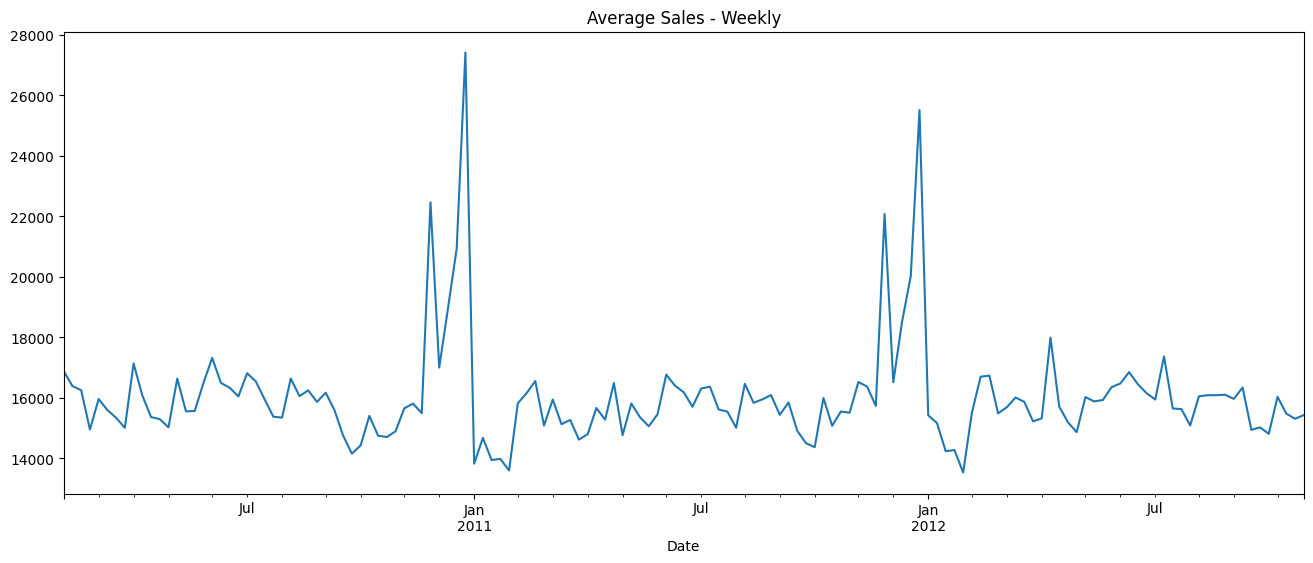

In [84]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

With the collecting data as weekly, I can see average sales clearly. To see monthly pattern , I resampled my data to monthly also.

In [85]:
df_month = df.resample('MS').mean() # resampling as monthly

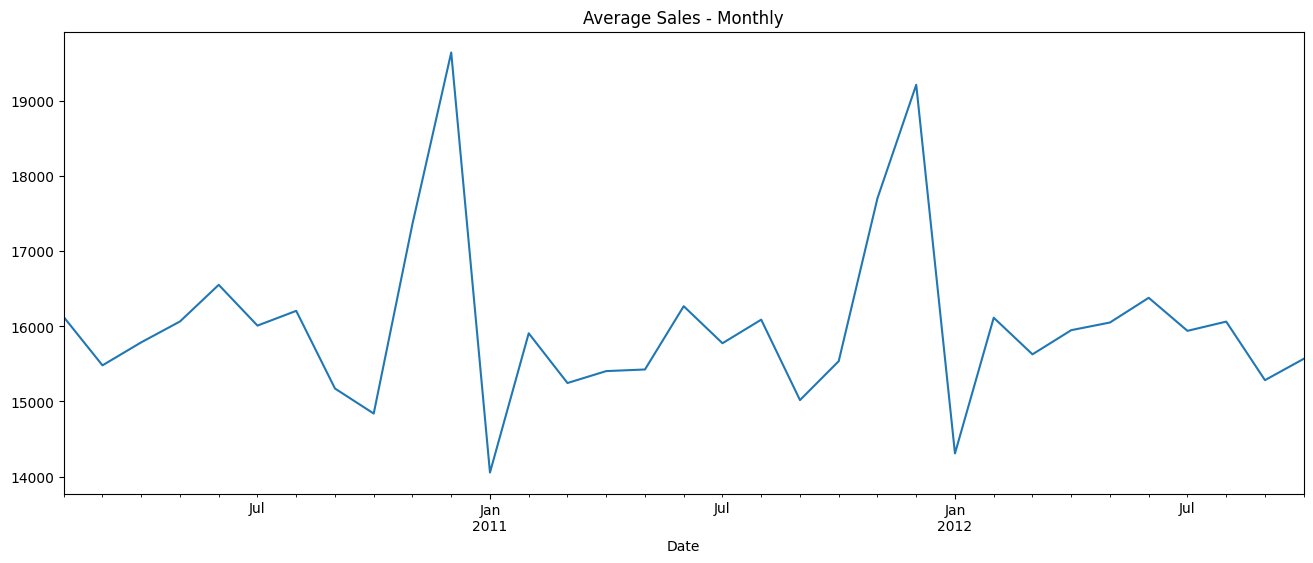

In [86]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

When I turned data to monthly, I realized that I lost some patterns in weekly data. So, I will continue with weekly resampled data.

## To Observe 2-weeks Rolling Mean and Std

My data is non-stationary. So, I will try to find more stationary version on it.

In [87]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

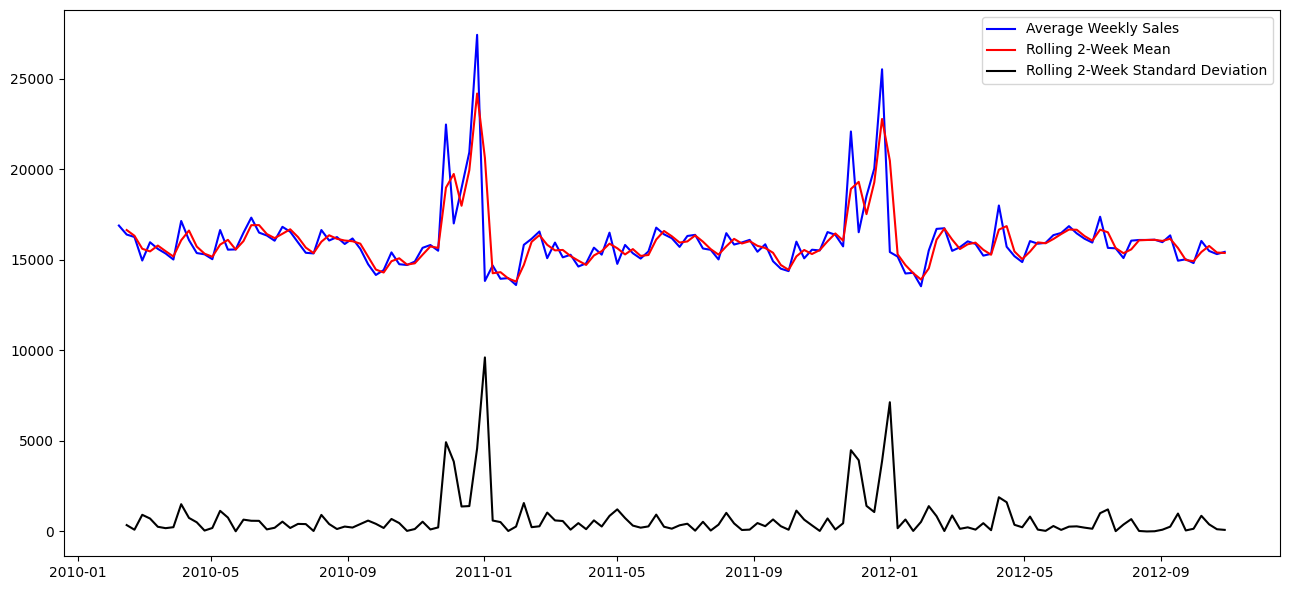

In [88]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

In [89]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737572,
 2.4290492082042356e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

From test and my observations my data is not stationary. So, I will try to find more stationary version of it.

## Train - Test Split of Weekly Data

To take train-test splits continuosly, I split them manually, not random.

In [90]:
train_data = df_week[:int(0.7*(len(df_week)))]
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 22)
Test: (43, 22)


In [91]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

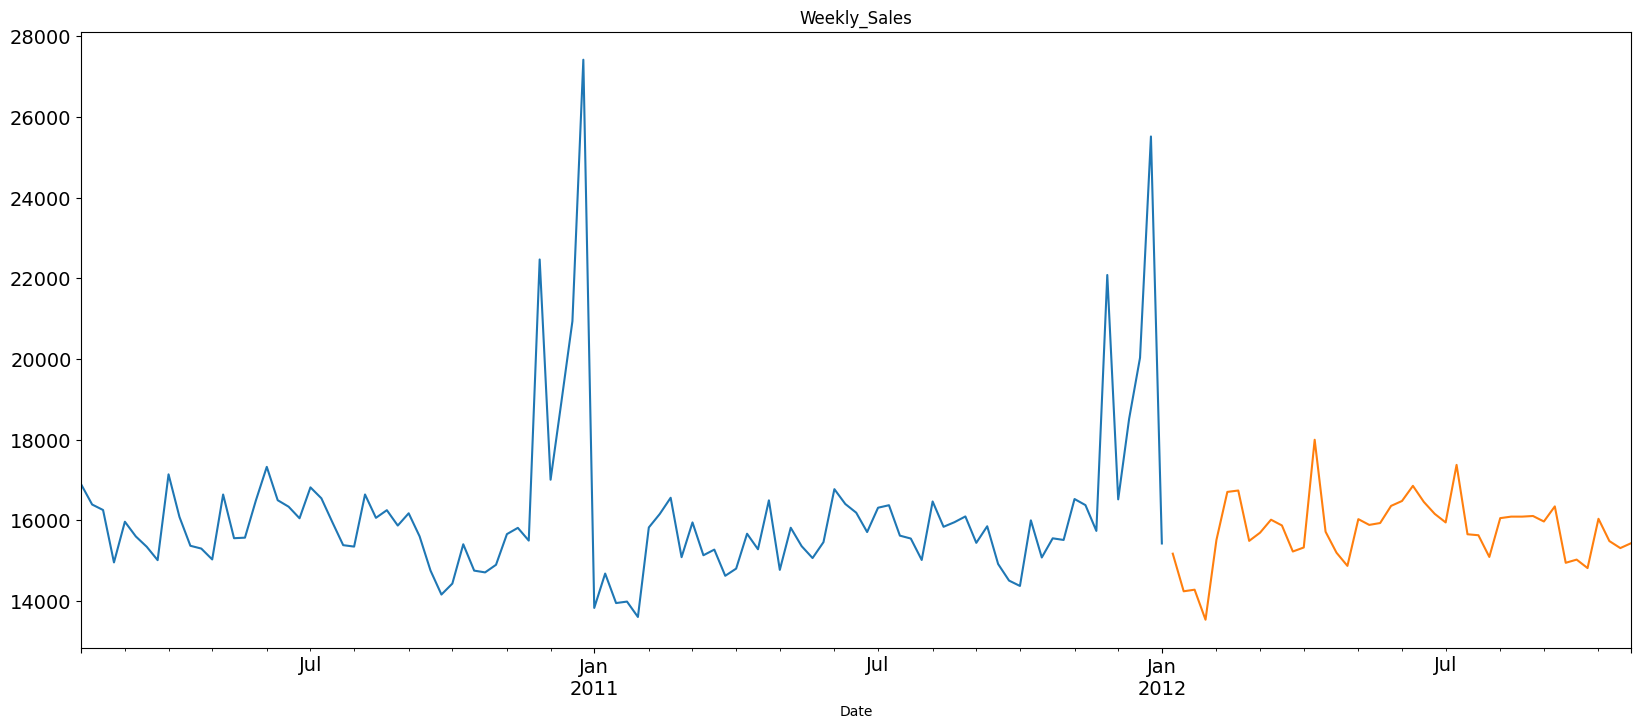

In [92]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

Blue line represents my train data, yellow is test data.

## Decomposing Weekly Data to Observe Seasonality

In [93]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data

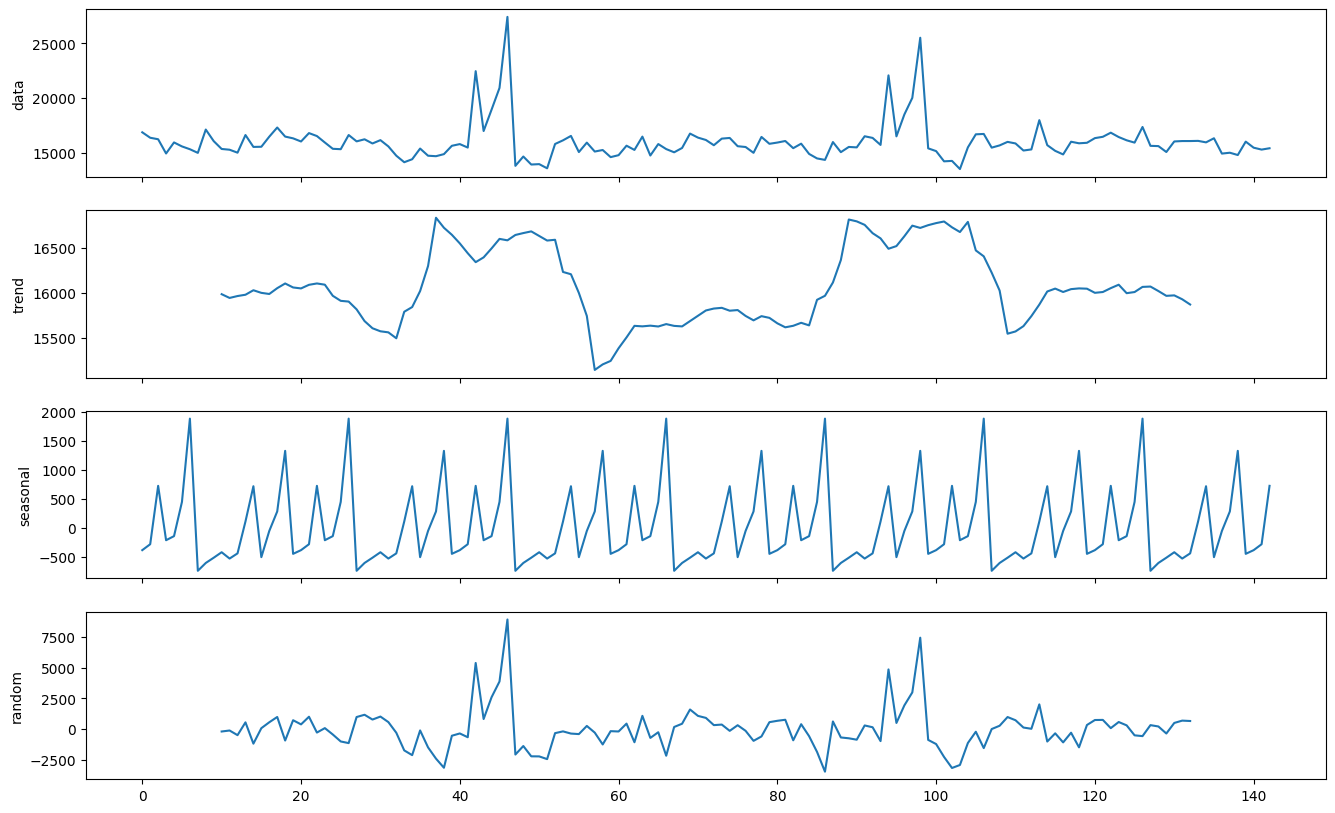

In [94]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. This helps me to tune my model.

## Trying To Make Data More Stationary

Now, I will try to make my data more stationary. To do this, I will try model with differenced, logged and shifted data.

## 1. Difference

In [95]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values

In [96]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

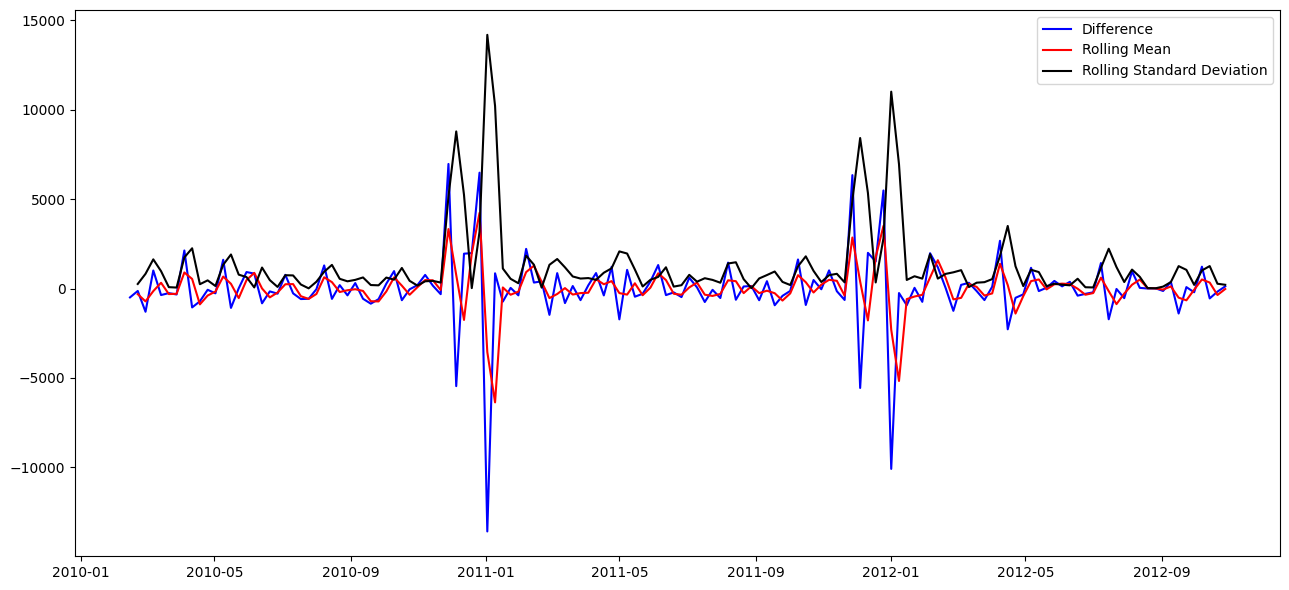

In [97]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 2.Shift

In [98]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data

In [99]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean()
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

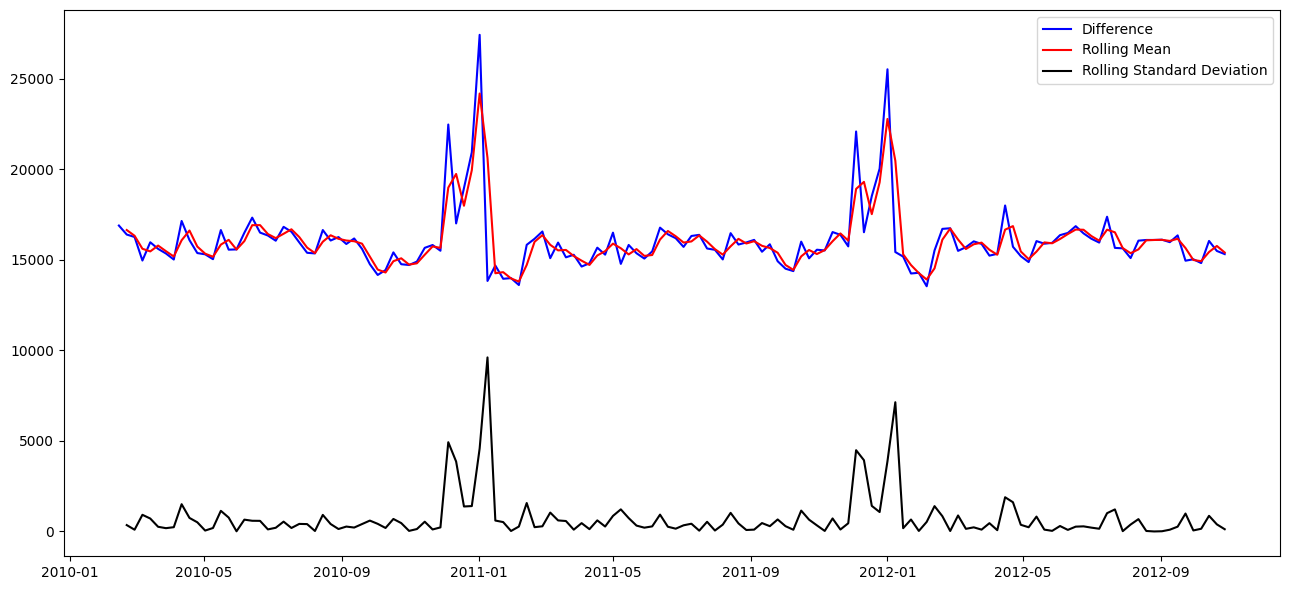

In [100]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 3.Log

In [101]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data

In [102]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

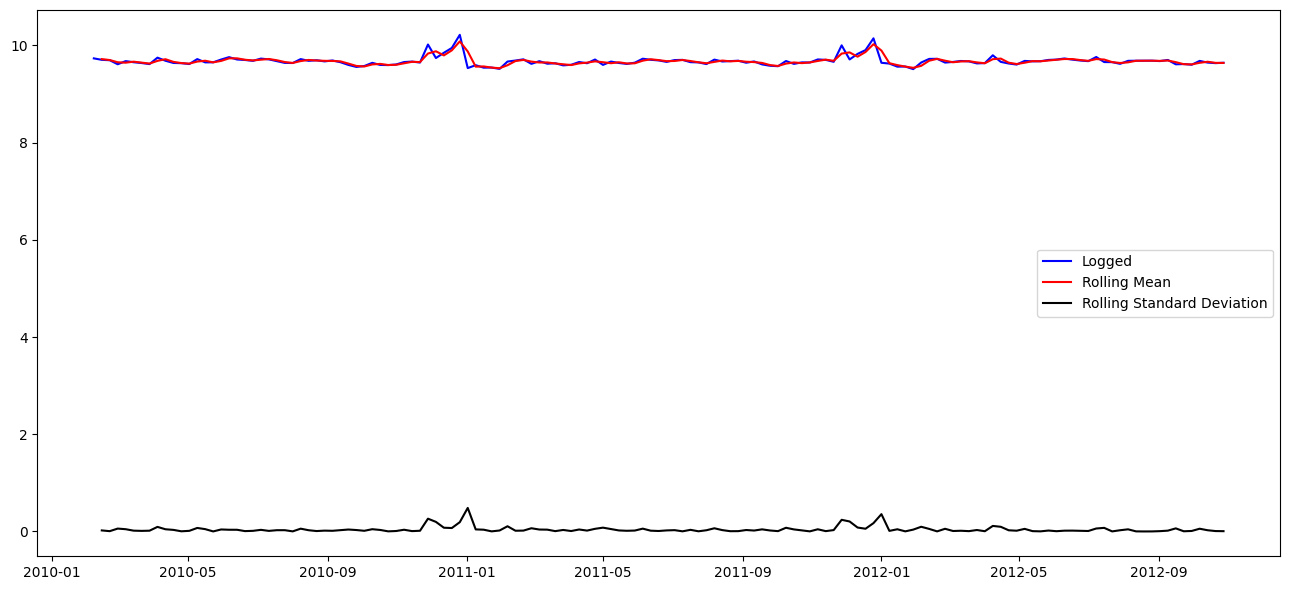

In [103]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## Auto-ARIMA MODEL

I tried my data without any changes, then tried with shifting, taking log and difference version of data. Differenced data gave best results. So, I decided to take difference and use this data.

## Train-Test Split

In [104]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [105]:
# train_data = train_data['Weekly_Sales']
# test_data = test_data['Weekly_Sales']

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

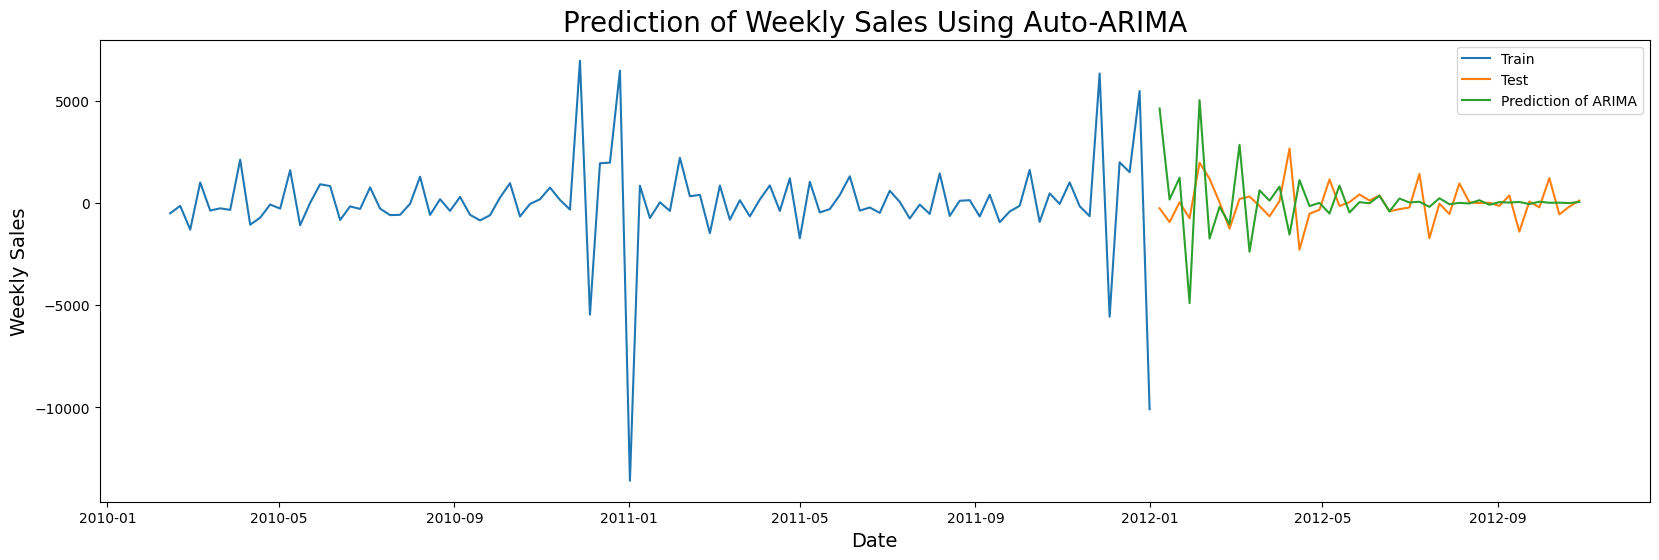

In [106]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

I do not like the pattern of predictions so I decided to try another model.

## ExponentialSmoothing

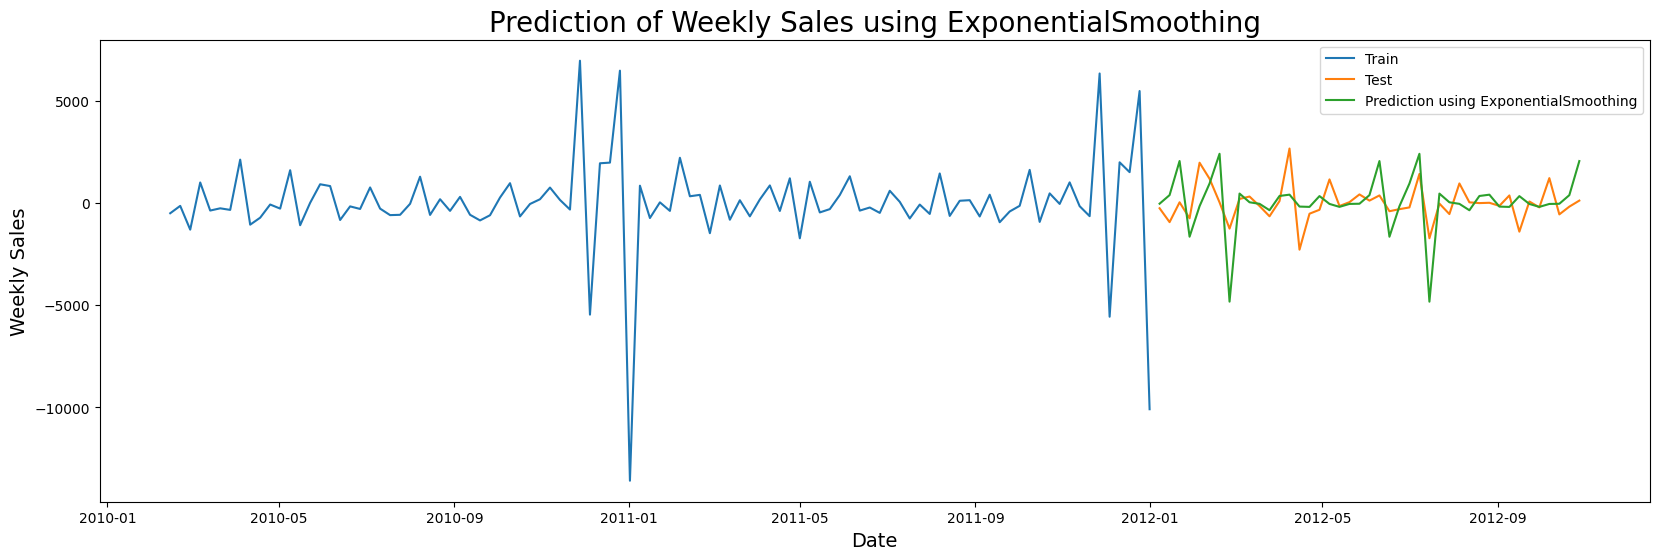

In [107]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [108]:
wmae_test(test_data_diff, y_pred)

840.681060966696

Best Model: Exponential Smoothing Model